In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pathresults = "../scripts/results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","
import re

evalTime = 25.

#path2file_ = r'newMucil/{}_1476_{}_10to11_20mn_0s_10/'

#path2file_ = r'CSTiminSame_exud4p/{}_1476_{}_10to25_20mn_0s_128/'


In [9]:
def getVal(mypath, filename,dtype=float,extension='.txt', header="infer",names = None):
    
    fullpath = pathresults +mypath+filename
    data_file_delimiter = ","
    if names is None:
        largest_column_count = 0
        with open(fullpath, 'r') as temp_f:
            lines = temp_f.readlines()
        last_line = lines[-1].strip()
        #print('last_line',last_line)
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        largest_column_count = len(array_from_last_line)
        names = [i for i in range(0, largest_column_count)]
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, 
                          header = header, names = names)
        #print('cst',cst.shape)
    else:
        cst = pd.read_csv(fullpath,delimiter=data_file_delimiter, header = header, names = names)
    return cst
    
def get_last_line_as_numpy_array(file_path,  dtype = float, verbose = False):
    with open(pathresults +file_path, 'r') as file:
        # Read all lines
        lines = file.readlines()

        # Check if there are any lines in the file
        if not lines:
            raise ValueError("The file is empty")

        # Get the last line
        
        try:
            last_line = lines[-1].strip()
        except:
            print('timeLine',file_path, len(lines))
            raise Exception

        # Split the last line by commas and convert to NumPy array
        array_from_last_line = np.array(last_line.split(','), dtype=dtype)
        if verbose:
            print(file_path, len(array_from_last_line), end=", ")

        return array_from_last_line

def getCylIdx(path2file):
    fileName = "rhizoSegsId.txt"
    fullpath = path2file+fileName
    rhizoSegsId = get_last_line_as_numpy_array(fullpath, dtype = int, verbose = True)
    print('rhizoSegsId',max(rhizoSegsId))
    return rhizoSegsId
    
def list_files_with_prefix(folder_path, prefix):
    file_names = []
    for file_name in os.listdir(pathresults+folder_path):
        if file_name.startswith(prefix):
            file_names.append(file_name)
    return file_names

# cylinder max konz (per cell)
def getData_(cid,gId,path2file):
    fileName = "cyl_val/Cyl_cellVol_"+str(gId)+".txt"
    cVol = get_last_line_as_numpy_array(path2file+fileName, dtype = float)
    if cid == volIdx:
        return sum(cVol)
    elif cid <= 9:
        if cid <= 2:# == 0:
            fileName = "cyl_val/Cyl_watercontent_"+str(gId)+".txt"
            theta = get_last_line_as_numpy_array(path2file+fileName,dtype = float)
            cVol *= theta#cm3 scv to cm3 water
            if cid == 0:
                return sum(cVol)
        fileName = "cyl_val/Cyl_content"+str(cid)+"_"+str(gId)+".txt"
        Q1 = get_last_line_as_numpy_array(path2file+fileName,  dtype = float)
        konz = sum(Q1)/sum(cVol) #mol/cm3 or cm3/cm3
        return konz
    raise Exception

plantData = {0:'Q_Ag',1:'Q_Rm',2:'Q_Gr',3: 'Q_Exud_tot', 4:'Q_Mucil_tot',
             5:'Q_Exud',
             6:'Q_Mucil',
             7:'Q_S_ST',
             8:'Q_S_meso',
             9:'trans' ,10:'psiXyl',
             11:'time',
             12:'pSet',13:'scenario'}

extensions = {0:'.txt',1:'.txt',2:'.txt',3: '.txt', 4:'.txt',
             5:'.txt',
             6:'.txt', 7:'.txt',8:'.txt', 9:'.txt', 10:'.txt',
              11:'.txt',12:'.txt',13:'.txt'}
colNames=np.array(list(plantData.values()))
nToGet = len(plantData)-3 # all except pset and scenario

scenarios = [ "baseline", "lateDry","earlyDry"]
setIds =[5,61]# ,44,49 [7,21, 47, 85]
exceptPset = []#[('baseline','19'),('baseline','47'),('baseline','83')]
#result_list_compExcept = [path2file.format(scenario, str(setId)) for scenario, setId in exceptPsets]
dataInput =  [(scenario, str(setId)) for scenario in scenarios 
              for setId in setIds if (scenario, str(setId)) 
              not in exceptPset ]
#result_list_comp = [path2file.format(dI[0], dI[1]) 
#                    for dI in dataInput]

#numPset = len(dataInput)


def getData():
    
    GiniAll = [[] for i in range(len(dataInput))]
    
    for idSet, dI in enumerate(dataInput):
        
        GiniAll_ = pd.DataFrame(columns=colNames)
        print(dI[0], dI[1],end =", ")

        path2file = path2file_.format(dI[0], dI[1])
        #print(path2file)

        time = np.array(list(
            pd.read_csv(pathresults + path2file + "time.txt", 
                           names = ["time","Qlight"])["time"][1:])) # because we have twice the initial value
        timemax = int((max(time))*10)/10
        #print('timemax',max(time),timemax, len(time))

        if(True):#timemax==25):


            for cid in range(nToGet):
                try:
                    if plantData[cid] == 'psiXyl':
                        Ginits = getVal(path2file,plantData[cid]+extensions[cid]
                                ).mean(axis=1)
                    else:
                        Ginits = getVal(path2file,plantData[cid]+extensions[cid]
                                ).sum(axis=1)
                    #print(plantData[cid])#,Ginits,type(Ginits))
                    GiniAll_[plantData[cid]]= Ginits
                except:
                    print('pass',cid, plantData[cid])
            GiniAll_[plantData[nToGet]]= time[:len(GiniAll_[plantData[nToGet]])]
            GiniAll_[plantData[nToGet+1]]= dI[1]
            GiniAll_[plantData[nToGet+2]]= dI[0]

        GiniAll[idSet] = GiniAll_
            
    return GiniAll #cid pSet rr
    


In [10]:
#path2file_ = r'TraiRhizo/paperSc/40{}_1440_{}_10to25_20mn_0s_4/'
path2file_ ="tillage/ylim/{}{}_1440_25to30_1mn_0s_32/"
setIds =[40]
dataInput =  [(40,'none') ]
GiniAll = getData()
dftemp=[]
for Gini in GiniAll:
    dftemptemp=pd.DataFrame(Gini)
    dftemp.append(dftemptemp)

40 none, pass 0 Q_Ag
pass 1 Q_Rm
pass 2 Q_Gr
pass 3 Q_Exud_tot
pass 4 Q_Mucil_tot
pass 5 Q_Exud
pass 6 Q_Mucil
pass 7 Q_S_ST
pass 8 Q_S_meso
pass 10 psiXyl


In [5]:

from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
l_styles = {5:'-',44:'-.',61:':'}
# Define the color dictionary
c_styles = {
    'baseline':'#377EB8',  # Blue
    'earlyDry':  '#4DAF4A' ,  # Green
    'lateDry': '#E41A1C'  # red
}
color_legend_elements = [
    Line2D([0], [0], color=c_styles['baseline'], lw=2, label='baseline'),
    Line2D([0], [0], color=c_styles['earlyDry'], lw=2, label='earlyDry'),
    Line2D([0], [0], color=c_styles['lateDry'], lw=2, label='lateDry')
]

# Line style legend
linestyle_legend_elements = [
    Line2D([0], [0], color='black', linestyle=l_styles[5], lw=2, label=5),
    #Line2D([0], [0], color='black', linestyle=l_styles[38], lw=2, label=38),
    Line2D([0], [0], color='black', linestyle=l_styles[44], lw=2, label=44),
    Line2D([0], [0], color='black', linestyle=l_styles[61], lw=2, label=61)
]

def dotheplot(toplot, cumsum,df, sizerows,sizecols_,namesyaxes=None,ncols=3, maxTime = None, indexlegend1=0, indexlegend2=1):
    nrows = len(toplot)
    #ncols = 3
    scenarios = [ "baseline","earlyDry", "lateDry"]
    sizecols = sizecols_*ncols

    cm3tommol = 1000*(1/18.01528)

    # higher than in the 1st paper
    # probably in part because i increased the kr of the roots
    cm3tommol = 1000*(1/18.01528)
    ratioTrans = 250 
    fig, ax = plt.subplots(nrows, ncols,figsize=(sizerows,sizecols))  # 2 rows, 2 columns
    for ddid, dd in enumerate(df):
        for rowid, tipi in enumerate(toplot): 
            try:
                try:
                    pset_ = int(dd['pSet'].unique()[0])
                except:
                    print('rowid', rowid,tipi)
                    print(dd['pSet'].unique())
                scenario_ = dd['scenario'].unique()[0]
                if ncols > 1:
                    colid = np.where(scenario_==np.array(scenarios))[0][0]
                else:
                    colid = 0
                factor = 1000
                rot = 0
                unit=" (mmol C)"
                if (tipi == "trans" )or (tipi =='psiXyl'):
                    factor = cm3tommol
                    unit = " (cm3)"

                if tipi == "psiXyl":
                    factor = 1.
                    rot =30
                ddd = dd[tipi]*factor
                tts = dd['time']
                if not cumsum:
                    tts = dd['time'][1:]
                    ddd = np.diff(ddd)*4

                if ncols > 1:
                    ax_ = ax[rowid, colid]
                else:
                    ax_ = ax[rowid]
                ax_.plot( tts,ddd,
                                                                 linewidth=3,
                             #label=f'{i}',
                             c=c_styles[dd['scenario'].unique()[0]],
                             linestyle=l_styles[int(dd['pSet'].unique()[0])])


                ax_.tick_params(axis='both', which='major', labelsize=18)
                ax_.tick_params(axis='y', which='major', labelrotation=rot, labelsize=18)
                if colid == 0:
                    if namesyaxes is not None:
                        ax_.set_ylabel(namesyaxes[tipi]+unit, fontsize=20)
                    else:
                        ax_.set_ylabel(tipi+unit, fontsize=20)
                if rowid == 0 and ncols > 1:
                    ax_.set_title(scenario_)
                if rowid == nrows-1:
                    ax_.set_xlabel('time (d)', fontsize=20)
                if True:
                    if scenario_ == "lateDry":
                        ax_.axvline(x=18, color='k', linestyle='--')
                        ax_.axvline(x=25, color='k', linestyle='--')
                    if scenario_ == "earlyDry":
                        ax_.axvline(x=18, color='k', linestyle='--')
                        ax_.axvline(x=11, color='k', linestyle='--')
                if maxTime is not None:
                    ax_.set_xlim(10, maxTime)

                if rowid + colid == indexlegend1:
                    ax_.legend(handles=color_legend_elements, 
                                                               fontsize=20,title_fontsize='25', title='scenario', 
                                                               loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.15),

                if rowid + colid == indexlegend2:
                    ax_.legend(handles=linestyle_legend_elements, 
                                                               fontsize=20,title_fontsize='25', title='parameter set', 
                                                               loc='upper left',  ncol=3)#bbox_to_anchor=(0.5, -0.3),
                    if False:

                        ax_.add_artist(plt.legend(handles=color_legend_elements, 
                                                                                  fontsize=20, title='scenario', 
                                                                                   title_fontsize='25',
                                                                                  loc='upper center',# bbox_to_anchor=anchor1,#(0.5, -0.15), 
                                                                                  ncol=3, framealpha=1))
                        ax_.add_artist(plt.legend(handles=linestyle_legend_elements, 
                                                                                  fontsize=20, title='parameter set', 
                                                                                   title_fontsize='25',
                                                                                  loc='upper center',# bbox_to_anchor=anchor2,#(0.5, -0.3), 
                                                                                  ncol=3, framealpha=1))

                    #ax_.legend() 
            except:
                print('jump',)
    plt.tight_layout()

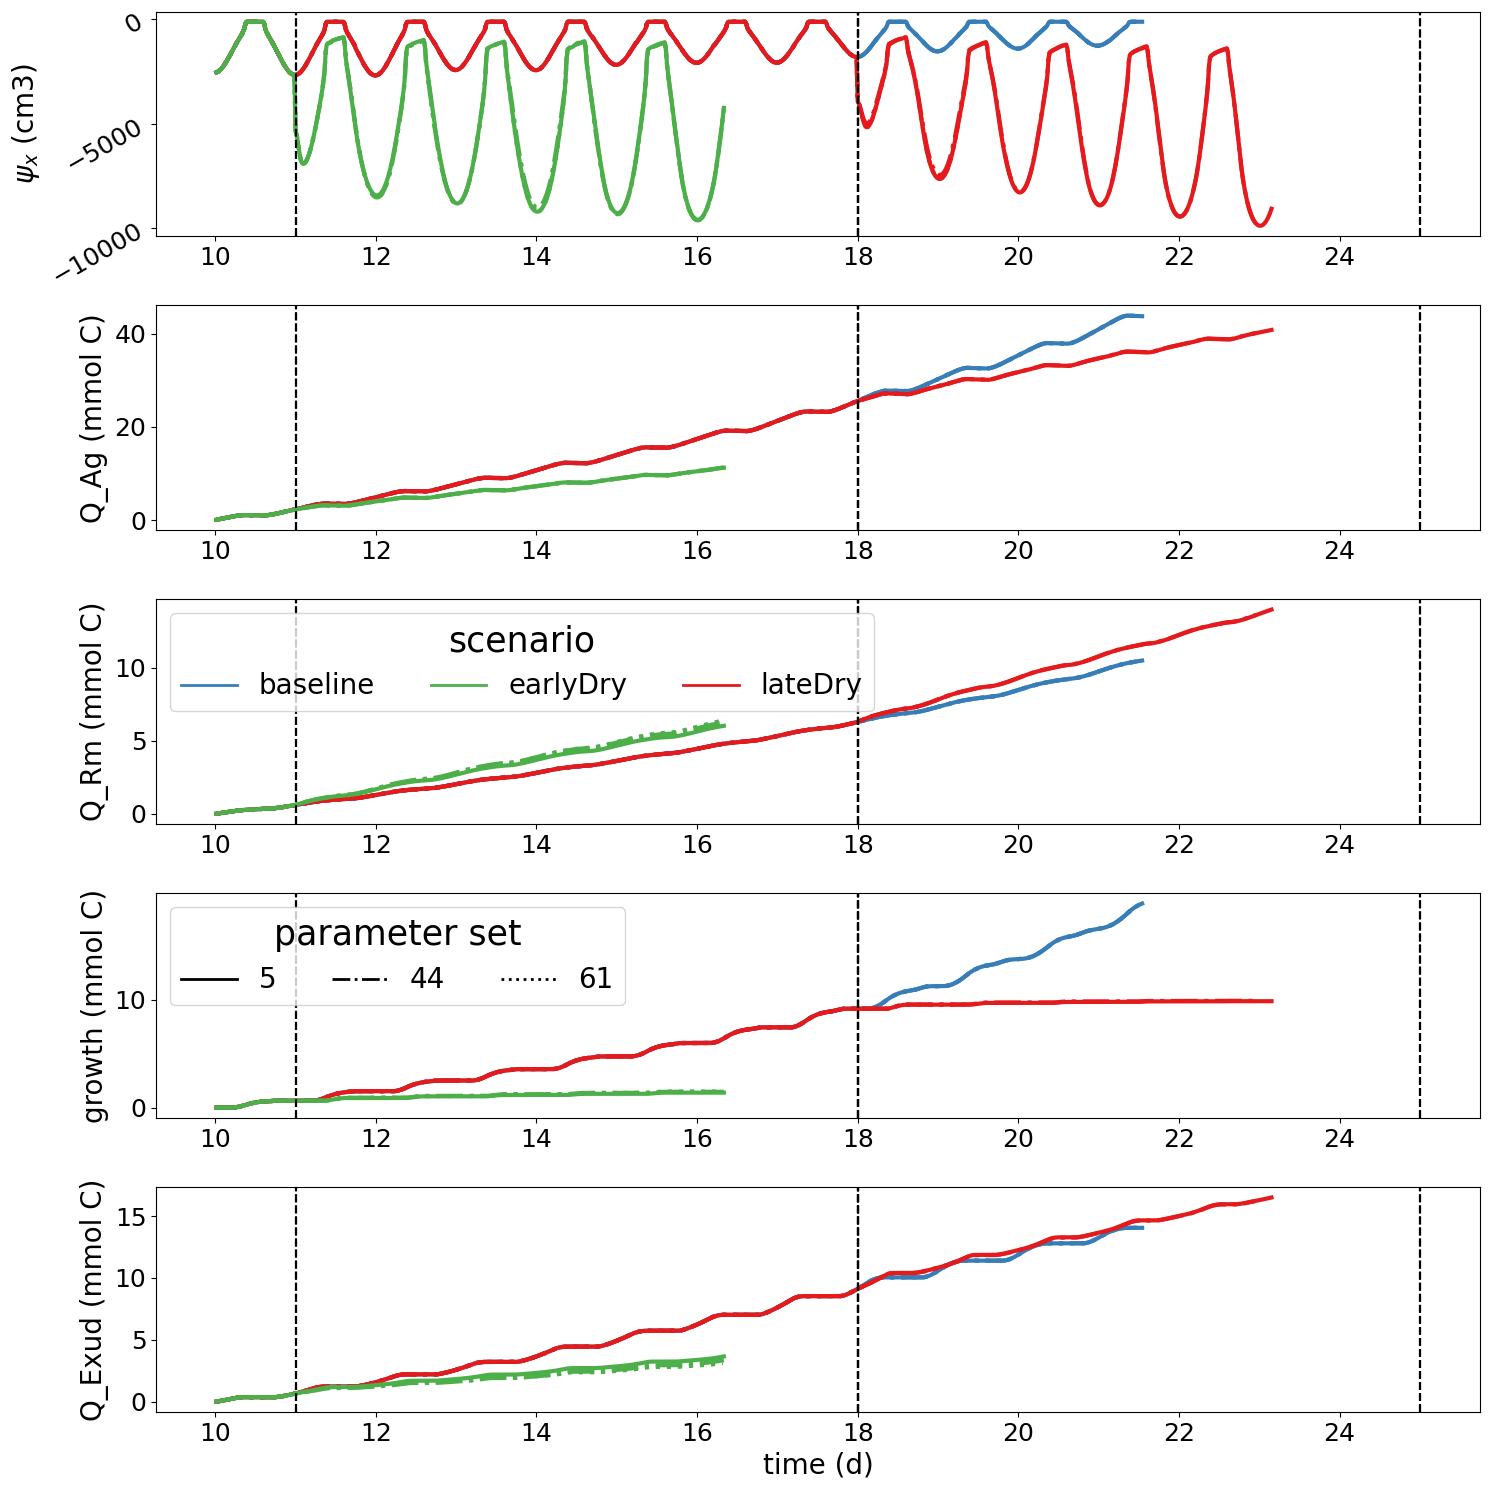

In [7]:

dotheplot(toplot =  ['psiXyl','Q_Ag','Q_Rm','Q_Gr','Q_Exud'],
          namesyaxes={'psiXyl':"$\psi_x$", 'Q_Gr':"growth", 'Q_Rm':"Q_Rm",'Q_Ag': "Q_Ag",'Q_Exud': "Q_Exud"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=2, indexlegend2=3)

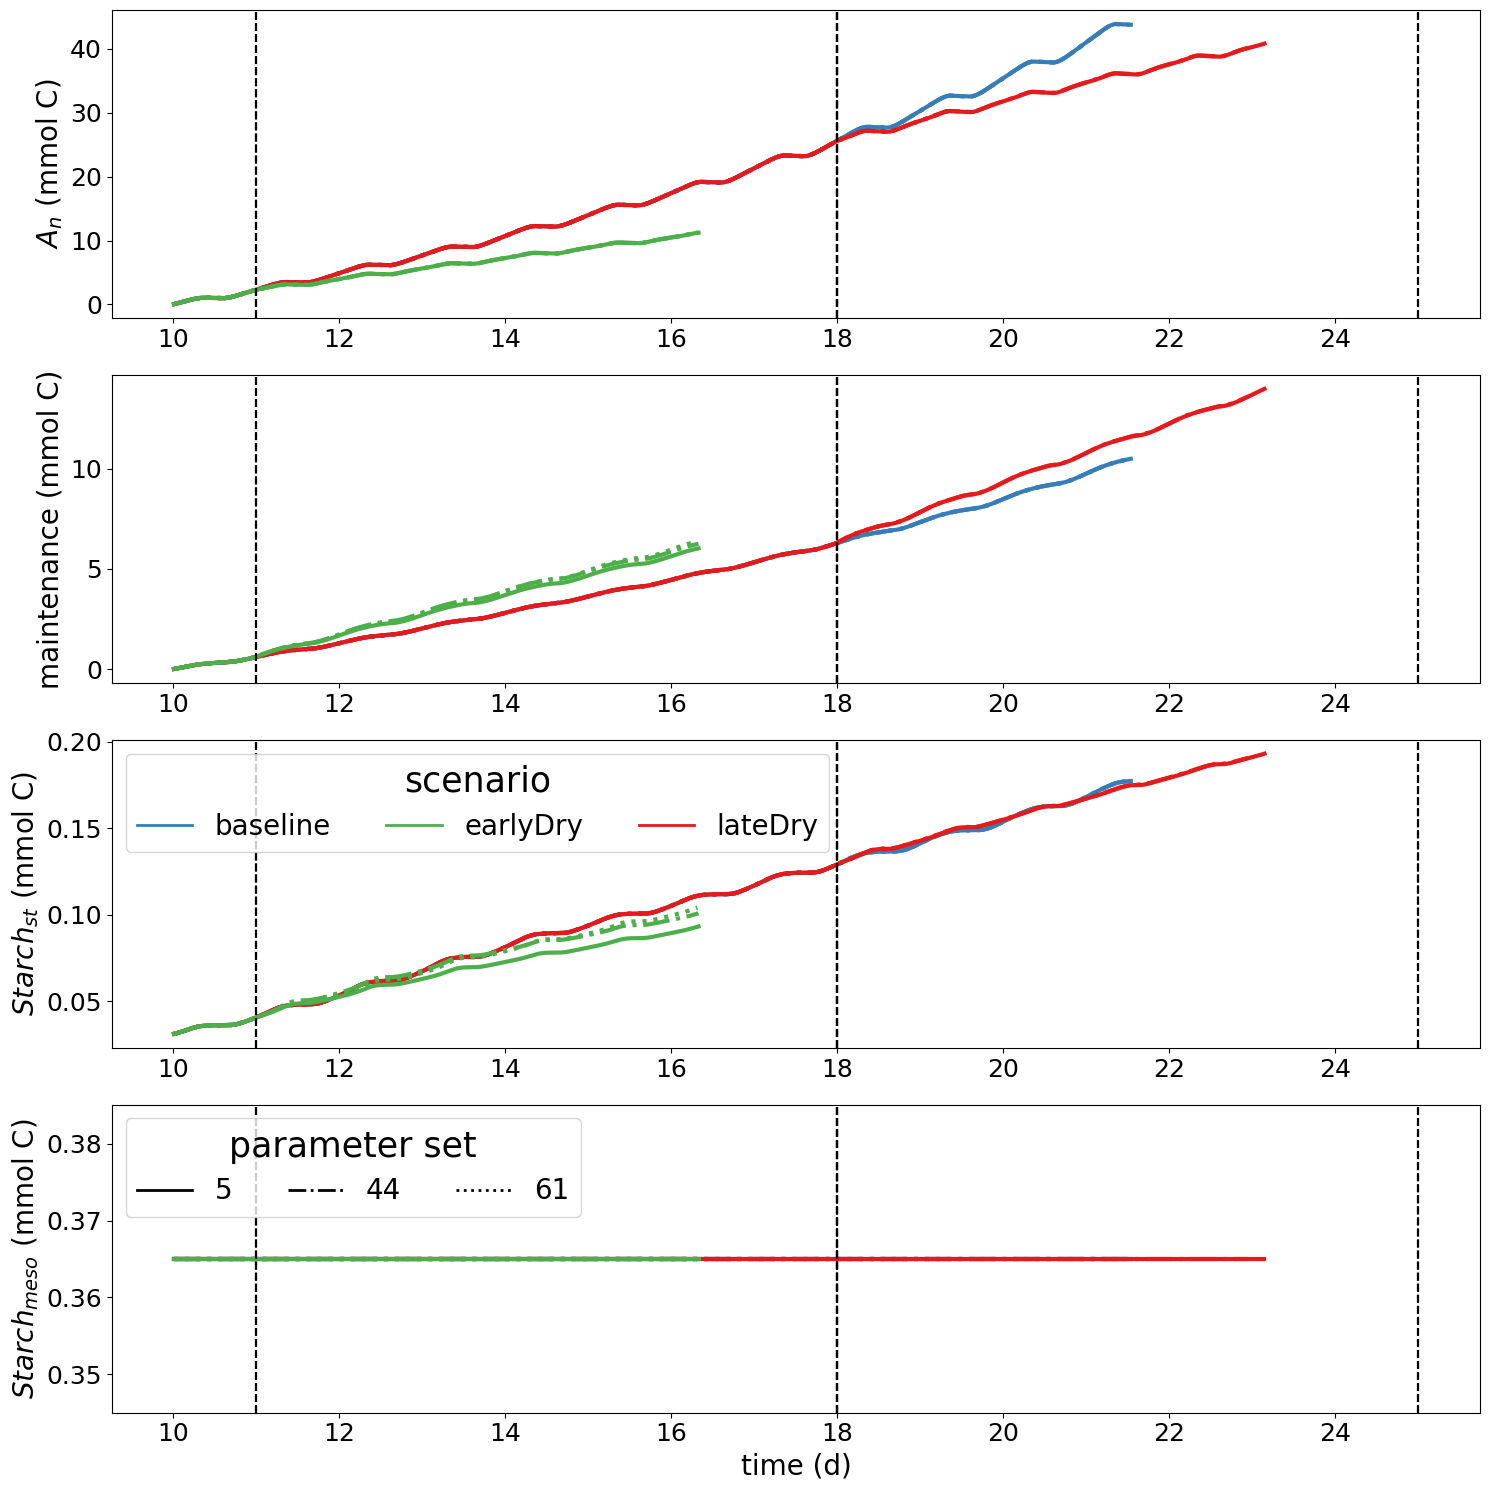

In [8]:

dotheplot(toplot =  ['Q_Ag','Q_Rm','Q_S_ST', 'Q_S_meso'],
          namesyaxes={'Q_Ag':"$A_n$", 'Q_Rm':"maintenance", 'Q_S_ST':"$Starch_{st}$",'Q_S_meso': "$Starch_{meso}$"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=2, indexlegend2=3)

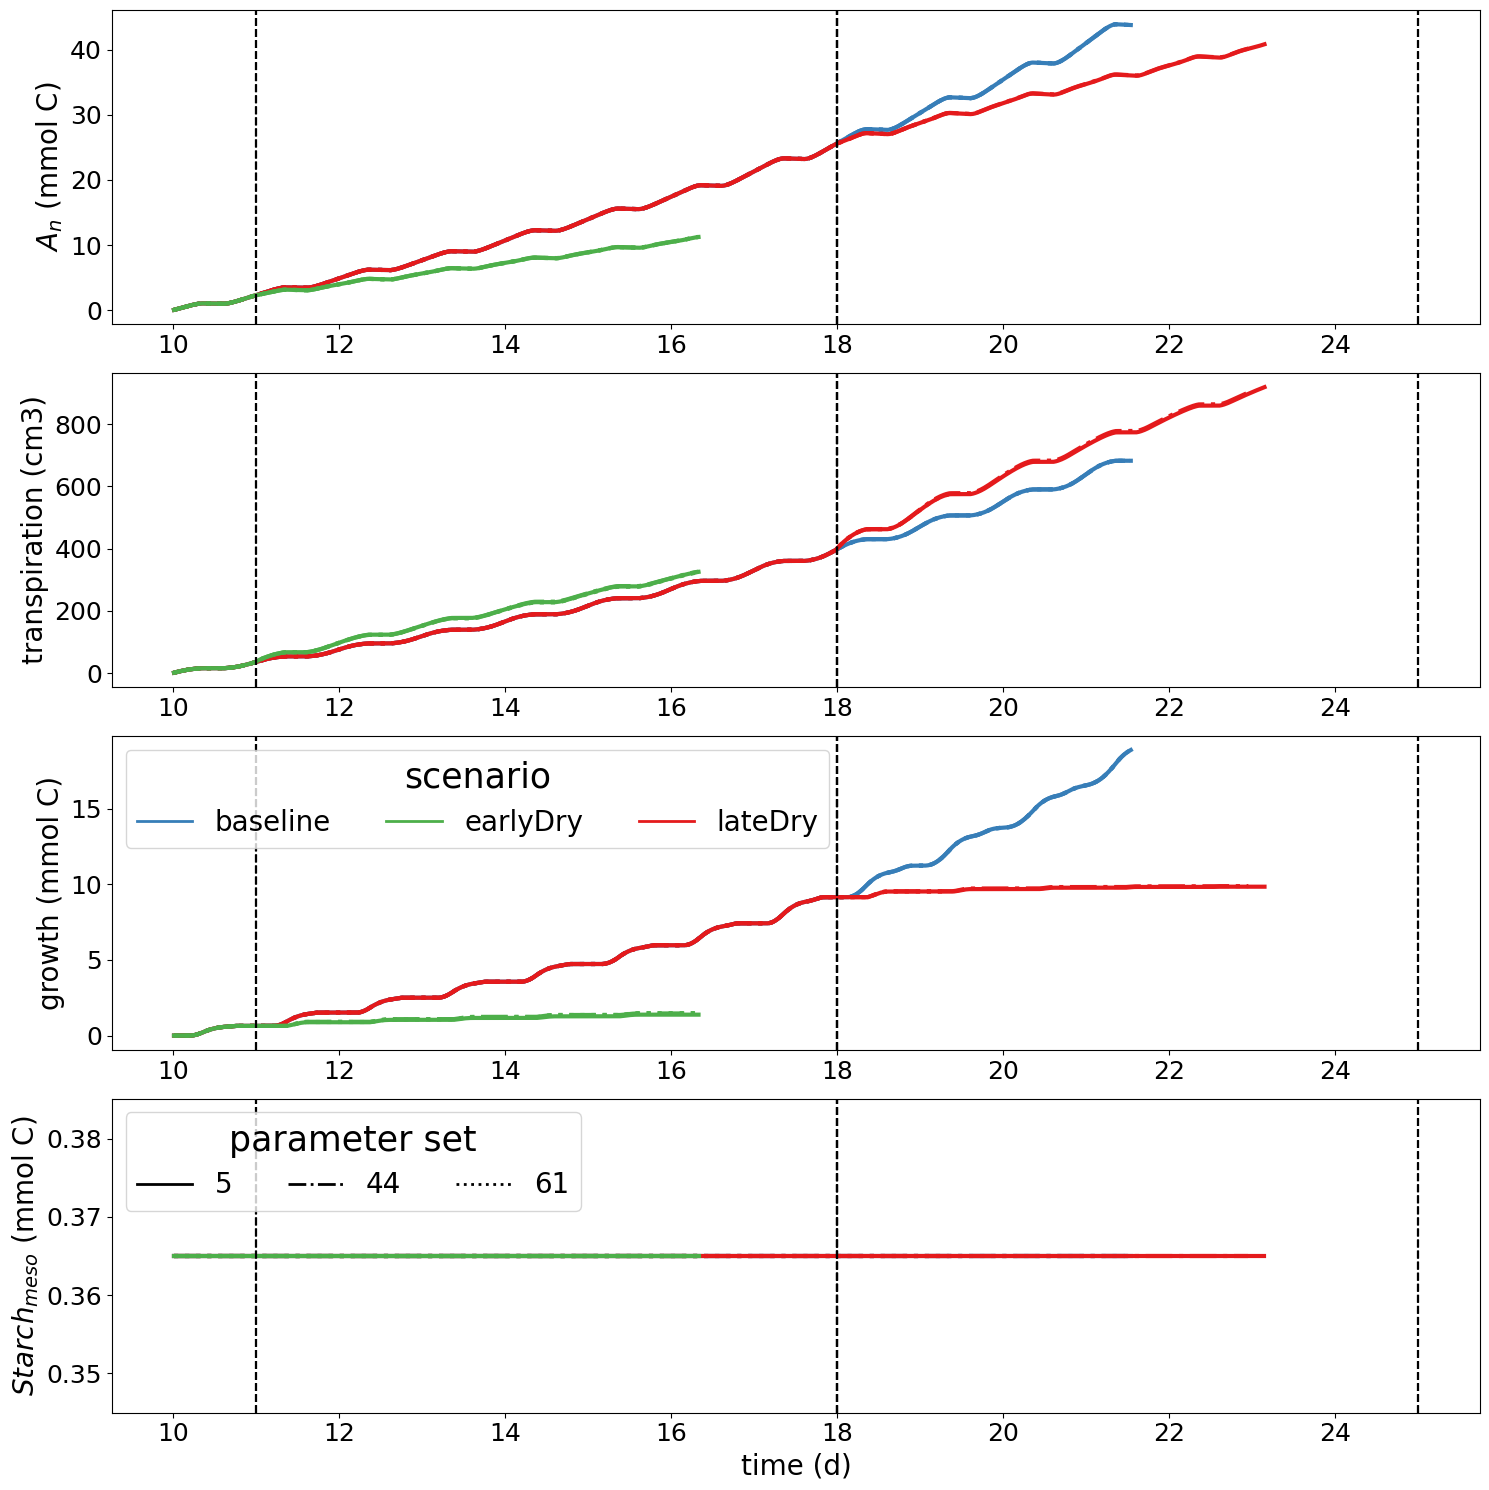

In [9]:

dotheplot(toplot =  ['Q_Ag','trans','Q_Gr', 'Q_S_meso'],
          namesyaxes={'Q_Ag':"$A_n$", 'trans':"transpiration", 'Q_Gr':"growth", 'Q_S_meso': "$Starch_{meso}$"},
          cumsum=True, df=dftemp, sizerows=15,sizecols_=15,ncols=1, indexlegend1=2, indexlegend2=3)

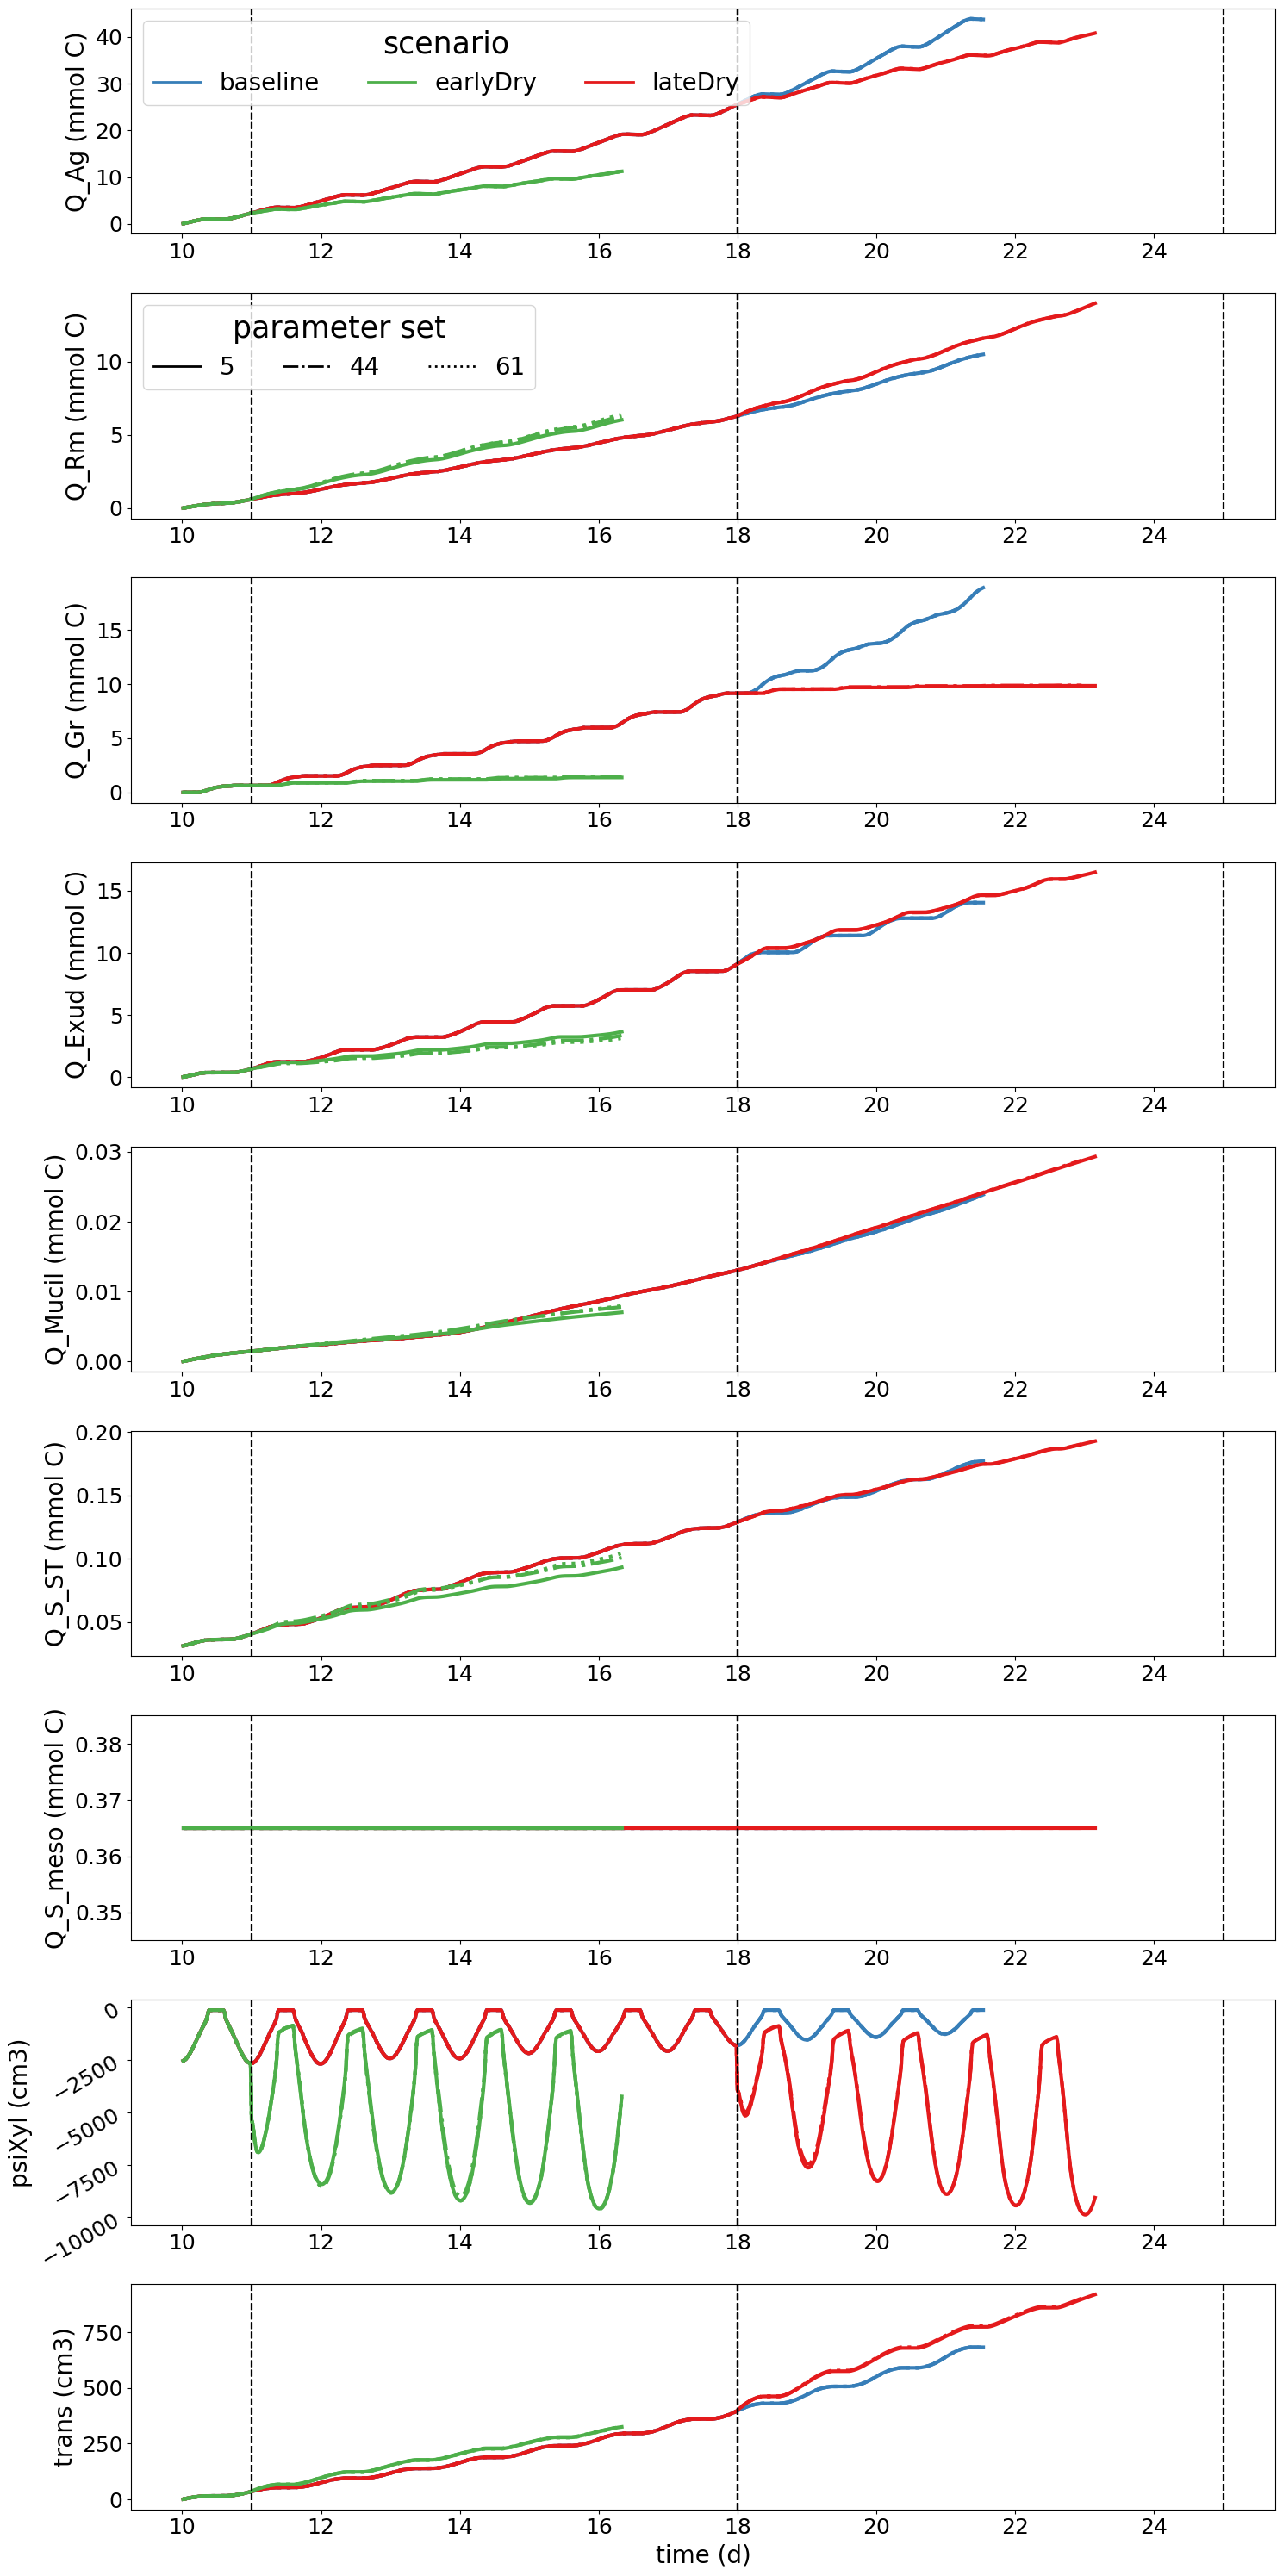

In [10]:

dotheplot(toplot =  ['Q_Ag','Q_Rm','Q_Gr', 'Q_Exud','Q_Mucil', #(toplot, cumsum,df, sizerows,sizecols,ncols=3, maxTime = None):
                     'Q_S_ST', 'Q_S_meso','psiXyl', 'trans'],
          cumsum=True, df=dftemp, sizerows=15,sizecols_=30,ncols=1)

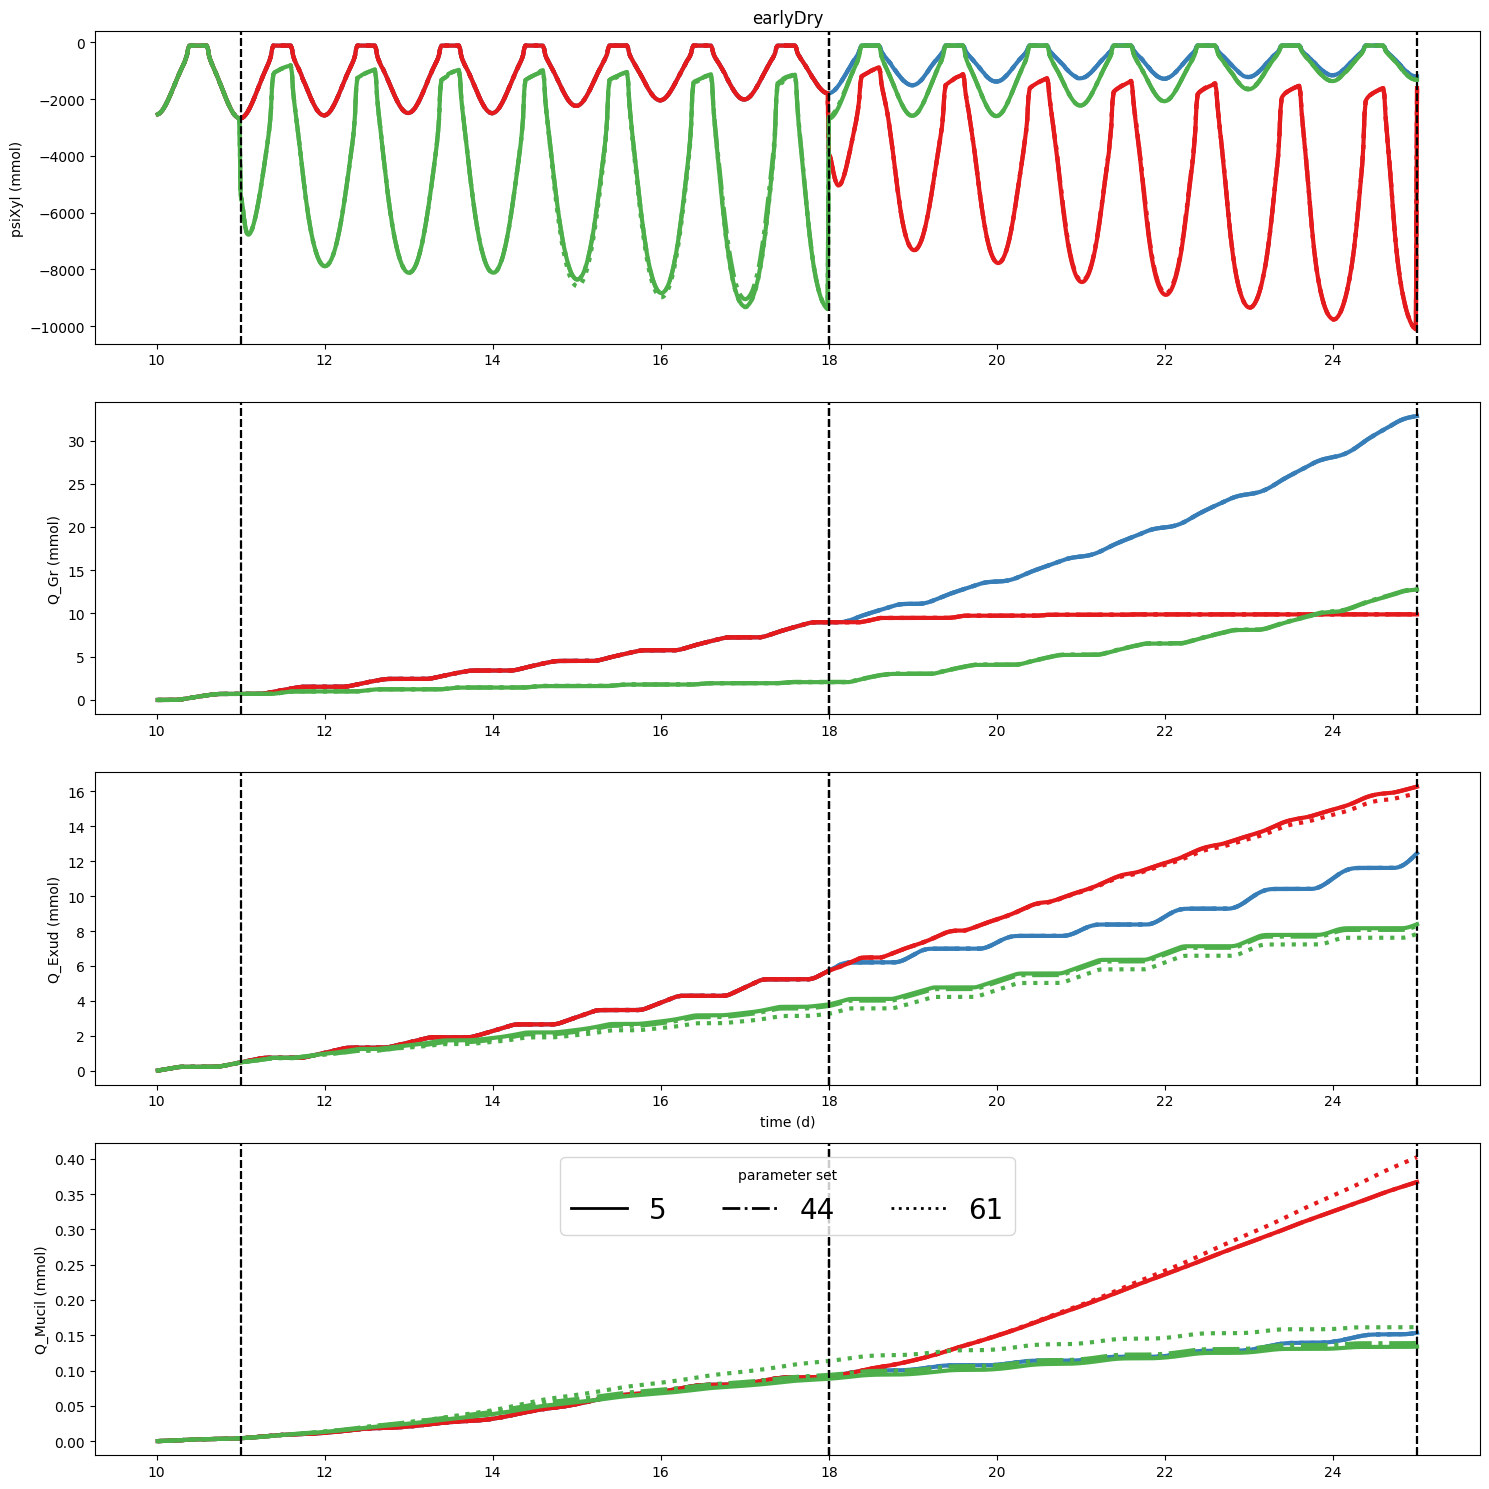

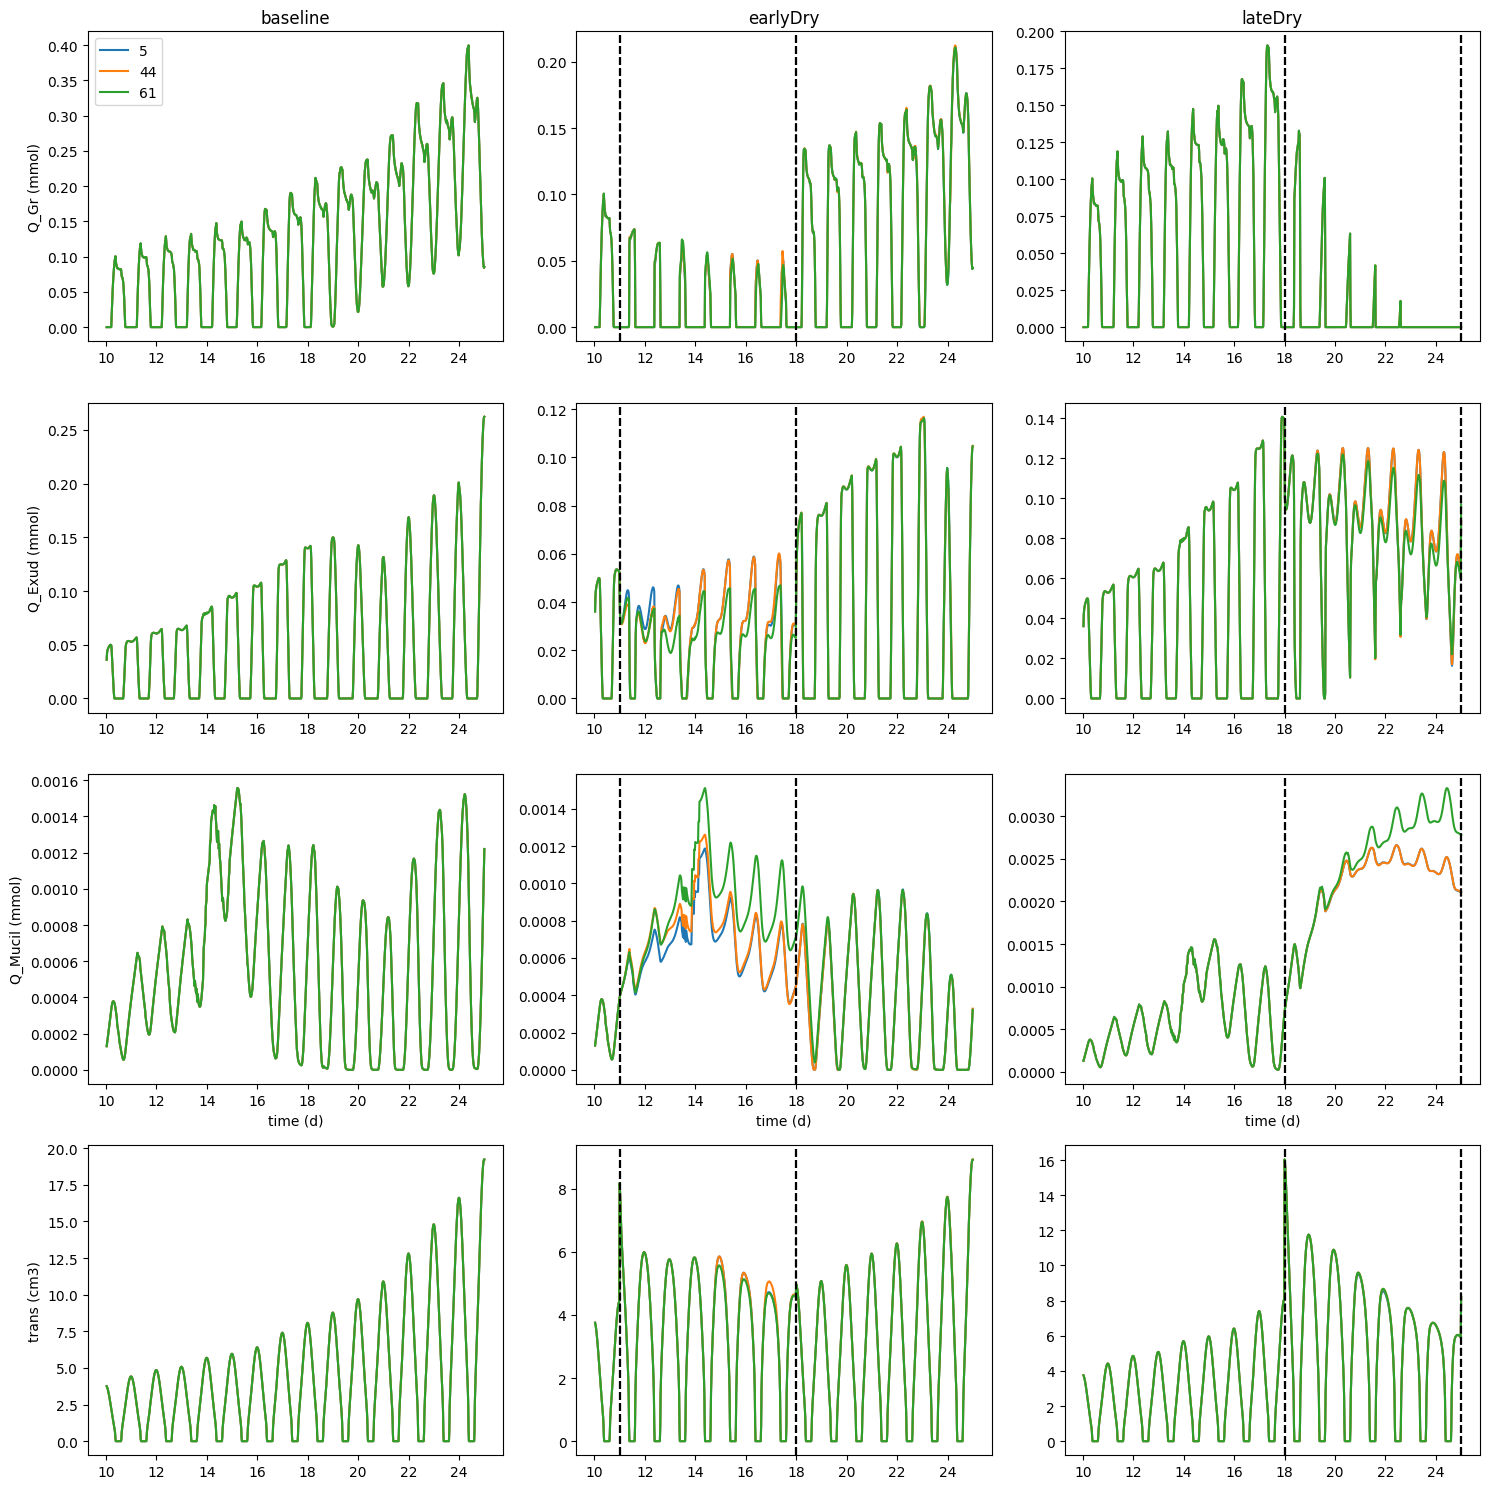

In [28]:

dotheplot(toplot =  ['Q_Gr','Q_Exud','Q_Mucil', 'trans'],
          cumsum=False, df=dftemp, sizerows=15,sizecols=15)

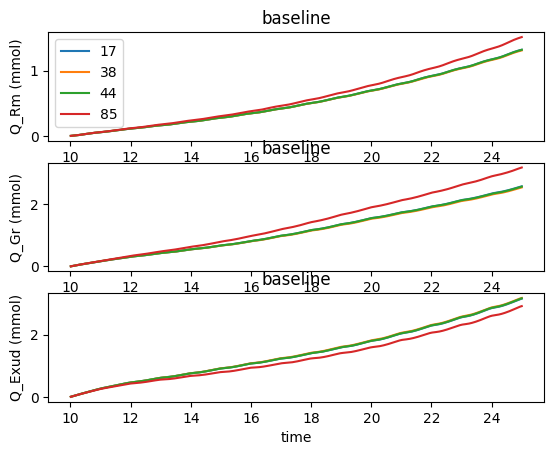

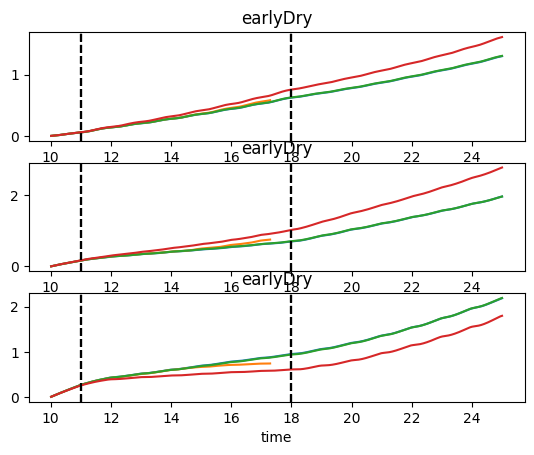

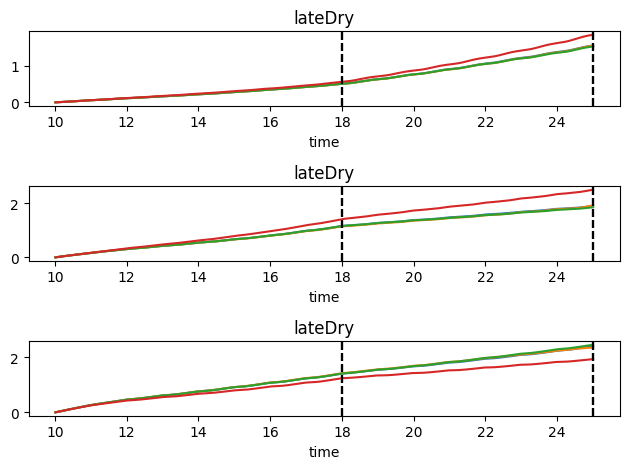

In [273]:

def dotheplotwithzoom(toplot, df, sizerows, sizecols):
    nrows = len(toplot)
    ncols = 3
    scenarios = ["baseline", "earlyDry", "lateDry"]

    cm3tommol = 1000 * (1 / 18.01528)

    # Create separate figures for each column
    figs = [plt.figure() for _ in range(ncols)]

    # Initialize separate axes arrays for each column
    axs = [[fig.add_subplot(nrows, 1, i+1) for i in range(nrows)] for fig in figs]

    for dd in df:
        for rowid, tipi in enumerate(toplot):
            pset_ = int(dd['pSet'].unique()[0])
            scenario_ = dd['scenario'].unique()[0]
            colid = np.where(scenario_ == np.array(scenarios))[0][0]
            factor = 1000
            if tipi == "trans":
                factor = cm3tommol
            axs[colid][rowid].plot(dd['time'], dd[tipi] * factor, label=pset_)
            axs[colid][rowid].set_xlabel('time')
            if colid == 0:
                axs[colid][rowid].set_ylabel(tipi + " (mmol)")
            axs[colid][rowid].set_title(scenario_)
            if scenario_ == "lateDry":
                axs[colid][rowid].axvline(x=18, color='k', linestyle='--')
                axs[colid][rowid].axvline(x=25, color='k', linestyle='--')
            if scenario_ == "earlyDry":
                axs[colid][rowid].axvline(x=18, color='k', linestyle='--')
                axs[colid][rowid].axvline(x=11, color='k', linestyle='--')
            if rowid + colid == 0:
                axs[colid][rowid].legend()

    plt.tight_layout()
    plt.show()


# Example usage:
# Assuming toplot, df, sizerows, and sizecols are defined
dotheplotwithzoom(toplot = ['Q_Rm','Q_Gr','Q_Exud'], df=df, sizerows=15,sizecols=15)